In [1]:
%load_ext watermark

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams['stats.credible_interval'] = 0.89

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 11.1

In [25]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


#### Code 11.2

In [26]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


#### Code 11.4 and 11.5

In [27]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0., 10.)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = az.from_pymc3(prior=prior_11_1)

with pm.Model() as m11_1bis:
    a = pm.Normal('a', 0., 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = az.from_pymc3(prior=prior_11_1bis)

#### Code 11.6

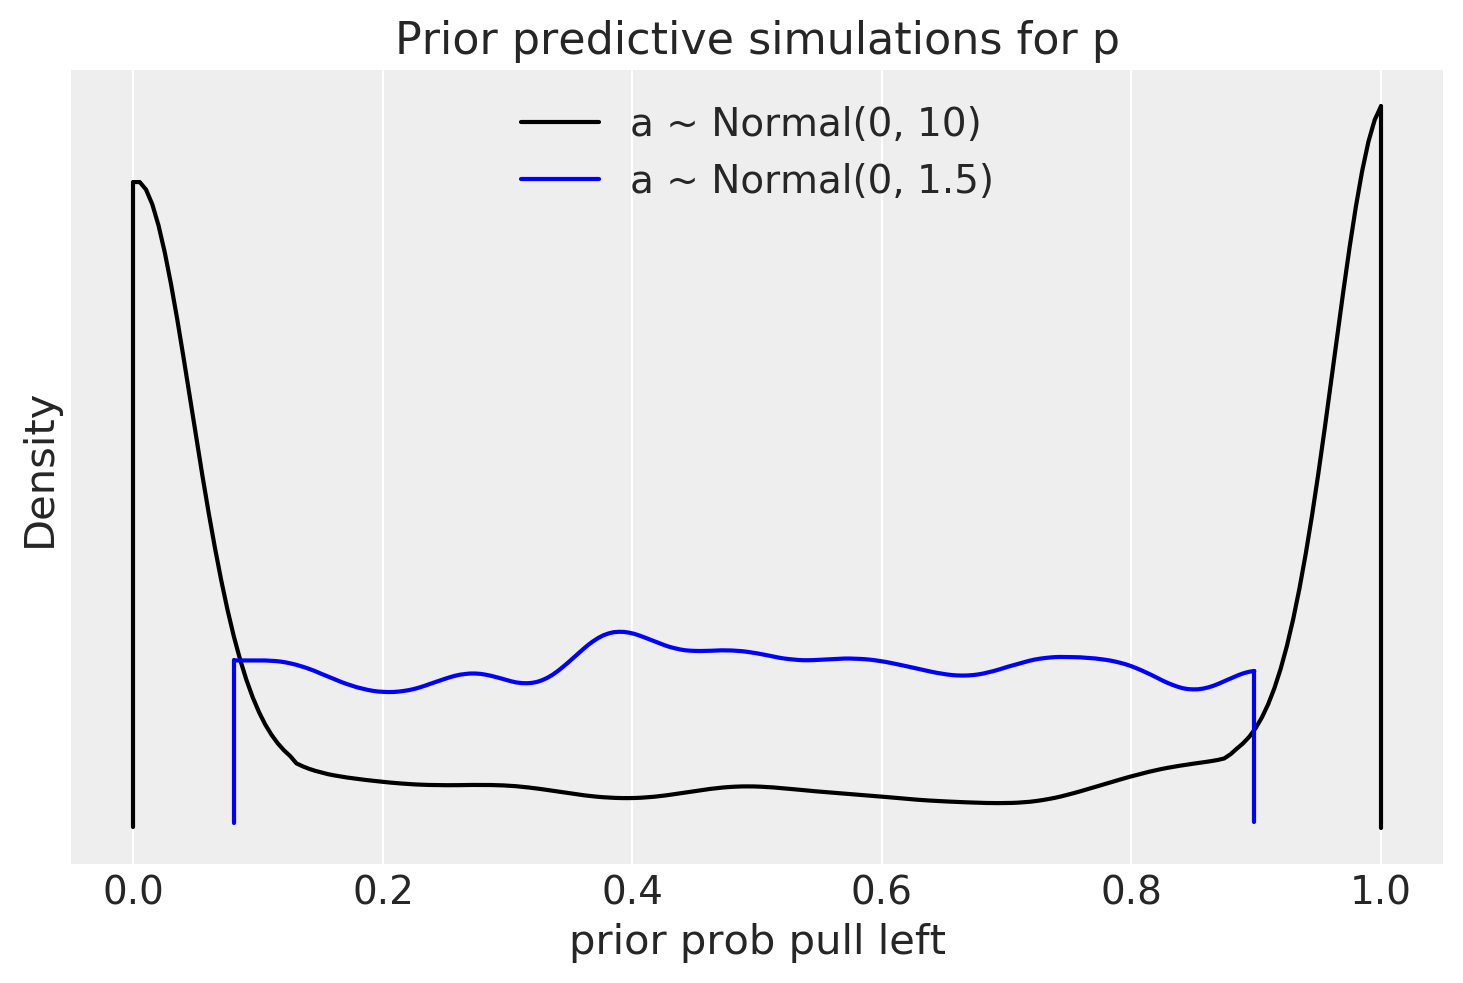

In [28]:
ax = az.plot_density([idata_11_1, idata_11_1bis], data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"], group="prior", colors=["k", "b"], var_names=["p"], point_estimate=None)
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

#### Code 11.7

In [29]:
with pm.Model() as m11_2:
    a = pm.Normal('a', 0., 1.5)
    b = pm.Normal('b', 0., 10., shape=4)
    
    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_2 = az.from_pymc3(prior=prior_11_2)
prior_2 = idata_11_2.prior

with pm.Model() as m11_3:
    a = pm.Normal('a', 0., 1.5)
    b = pm.Normal('b', 0., 0.5, shape=4)
    
    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_3 = az.from_pymc3(prior=prior_11_3)
prior_3 = idata_11_3.prior

#### Code 11.8

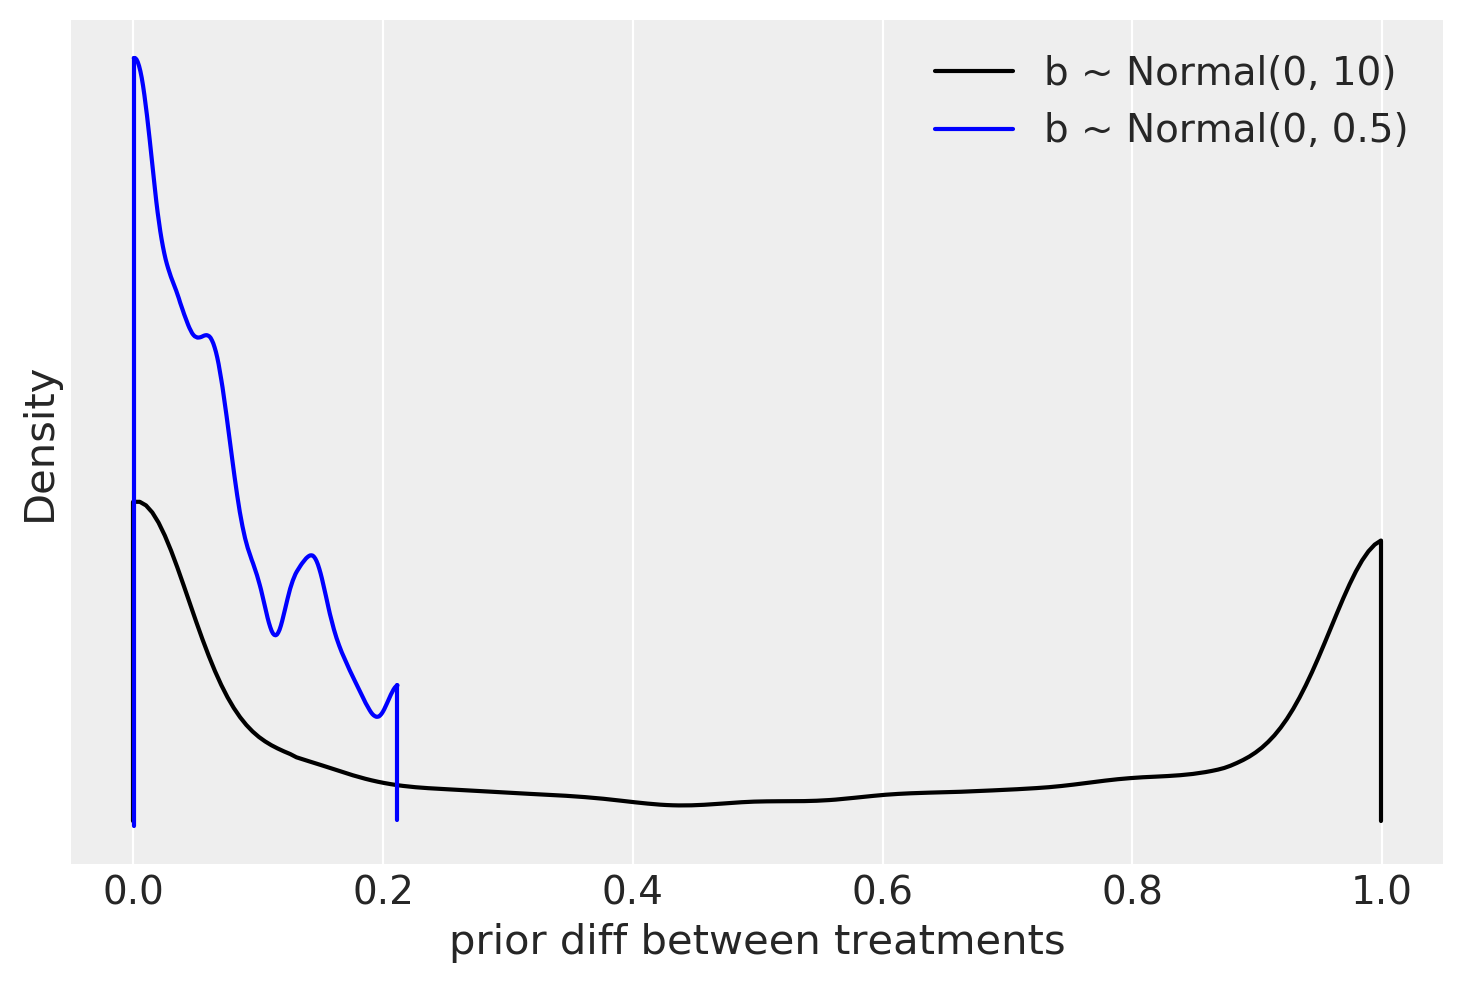

In [30]:
p_treat1, p_treat2 = logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0 = 0)), logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0 = 1))
p_treat1_bis, p_treat2_bis = logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0 = 0)), logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0 = 1))

ax = az.plot_density([np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values], 
                     data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"], group="prior", colors=["k", "b"], point_estimate=None)
ax[0].set_xlabel("prior diff between treatments")
ax[0].set_ylabel("Density")
ax[0].set_title(None);

#### Code 11.9

In [31]:
np.abs(p_treat1_bis - p_treat2_bis).mean().values

array(0.09629389)

#### Code 11.10

In [32]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

#### Code 11.11

In [33]:
with pm.Model() as m11_4:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    b = pm.Normal('b', 0., 0.5, shape=len(treatments))
    
    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(tune=1000, random_seed=RANDOM_SEED)
idata_11_4 = az.from_pymc3(trace_11_4)
az.summary(idata_11_4, var_names=["a", "b"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.34,-0.98,0.10,0.01,0.01,904.02,904.02,906.49,1233.25,1.0
a[1],3.89,0.77,2.70,5.16,0.02,0.01,1662.46,1519.62,1727.43,1041.72,1.0
a[2],-0.76,0.34,-1.32,-0.26,0.01,0.01,920.71,901.91,923.84,1220.99,1.0
a[3],-0.76,0.33,-1.27,-0.21,0.01,0.01,921.17,899.91,925.35,1402.90,1.0
a[4],-0.46,0.33,-0.99,0.05,0.01,0.01,804.67,804.67,803.08,1264.72,1.0
a[5],0.47,0.33,-0.07,0.95,0.01,0.01,985.84,985.84,981.28,1329.78,1.0
a[6],1.94,0.42,1.26,2.57,0.01,0.01,1199.67,1185.58,1201.59,1482.44,1.0
b[0],-0.04,0.29,-0.52,0.39,0.01,0.01,778.84,778.84,773.57,1272.13,1.0
b[1],0.48,0.29,0.05,0.96,0.01,0.01,807.97,776.91,807.51,1151.41,1.0
b[2],-0.38,0.29,-0.84,0.08,0.01,0.01,828.71,828.71,828.68,1342.87,1.0


#### Code 11.12

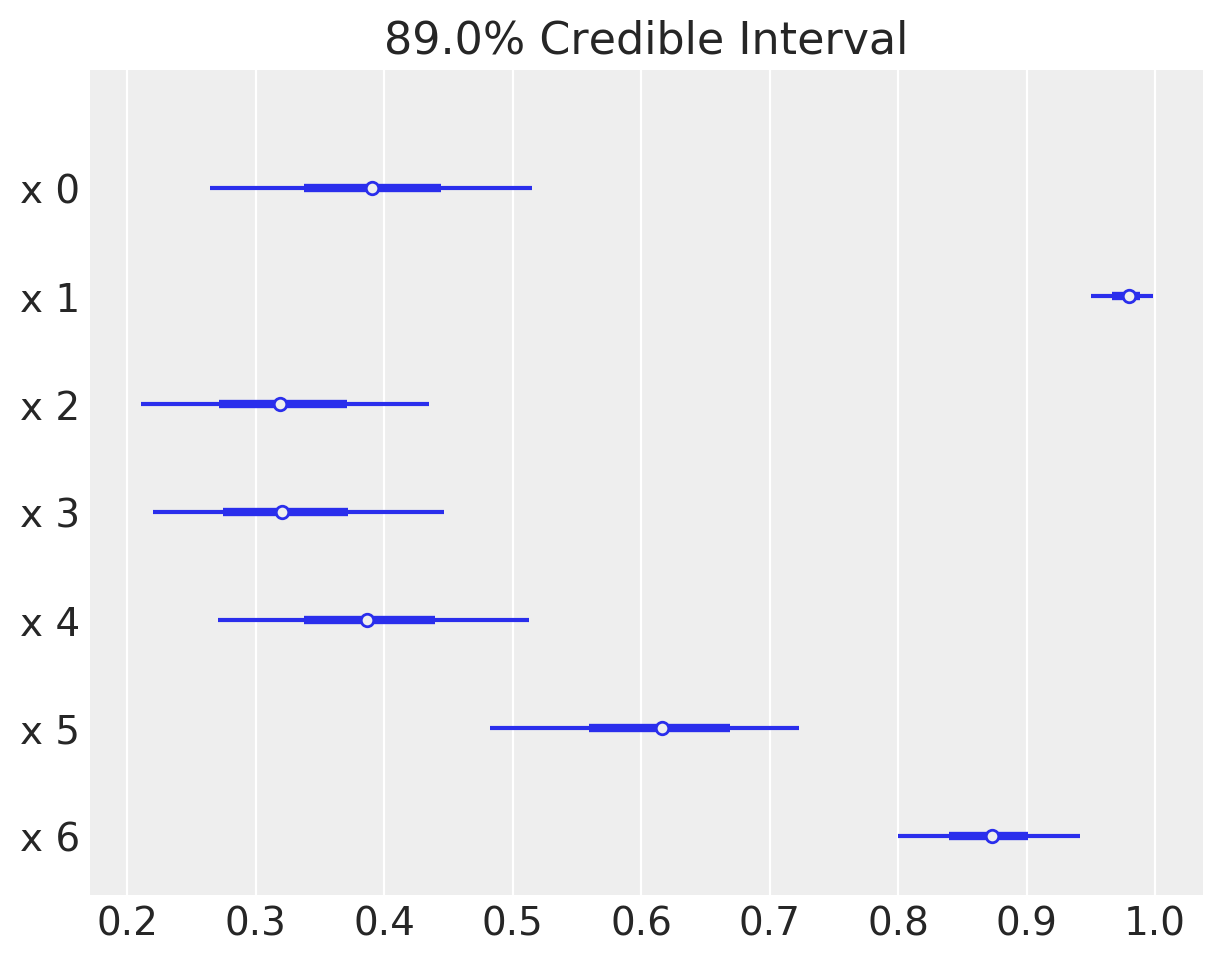

In [34]:
post = idata_11_4.posterior
p_left = logistic(post["a"])
az.plot_forest(p_left.values, combined=True);

#### Code 11.13

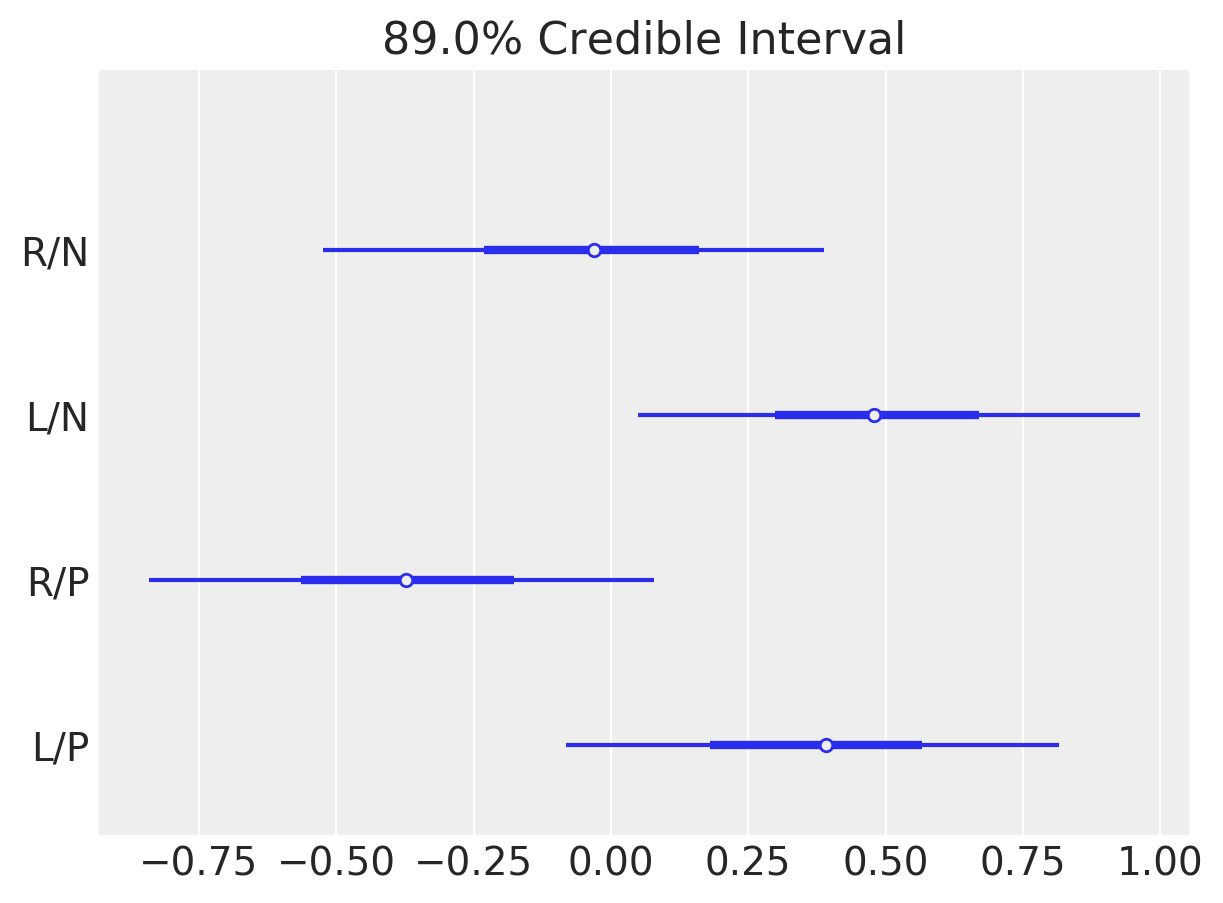

In [35]:
ax = az.plot_forest(idata_11_4, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

#### Code 11.14

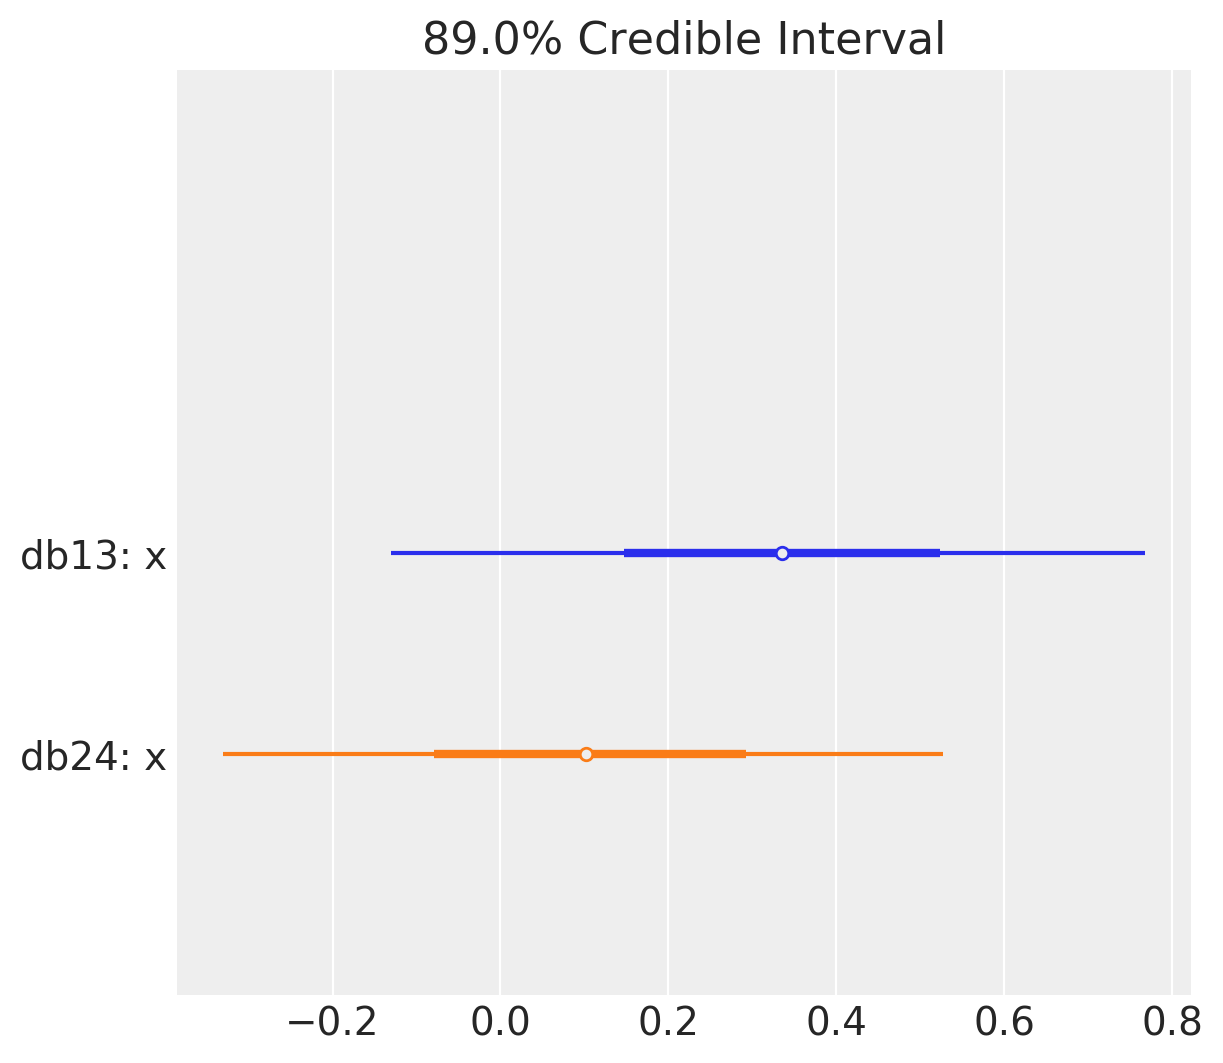

In [36]:
db13 = idata_11_4.posterior["b"].sel(b_dim_0 = 0) - idata_11_4.posterior["b"].sel(b_dim_0 = 2)
db24 = idata_11_4.posterior["b"].sel(b_dim_0 = 1) - idata_11_4.posterior["b"].sel(b_dim_0 = 3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);

#### Code 11.15

In [37]:
pl = d.groupby(['actor', 'treatment']).agg('mean')['pulled_left'].unstack()
pl

treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


#### Code 11.16 and 11.17

In [38]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])["p"]
p_mu = p_post.mean(0).reshape((7, 4))

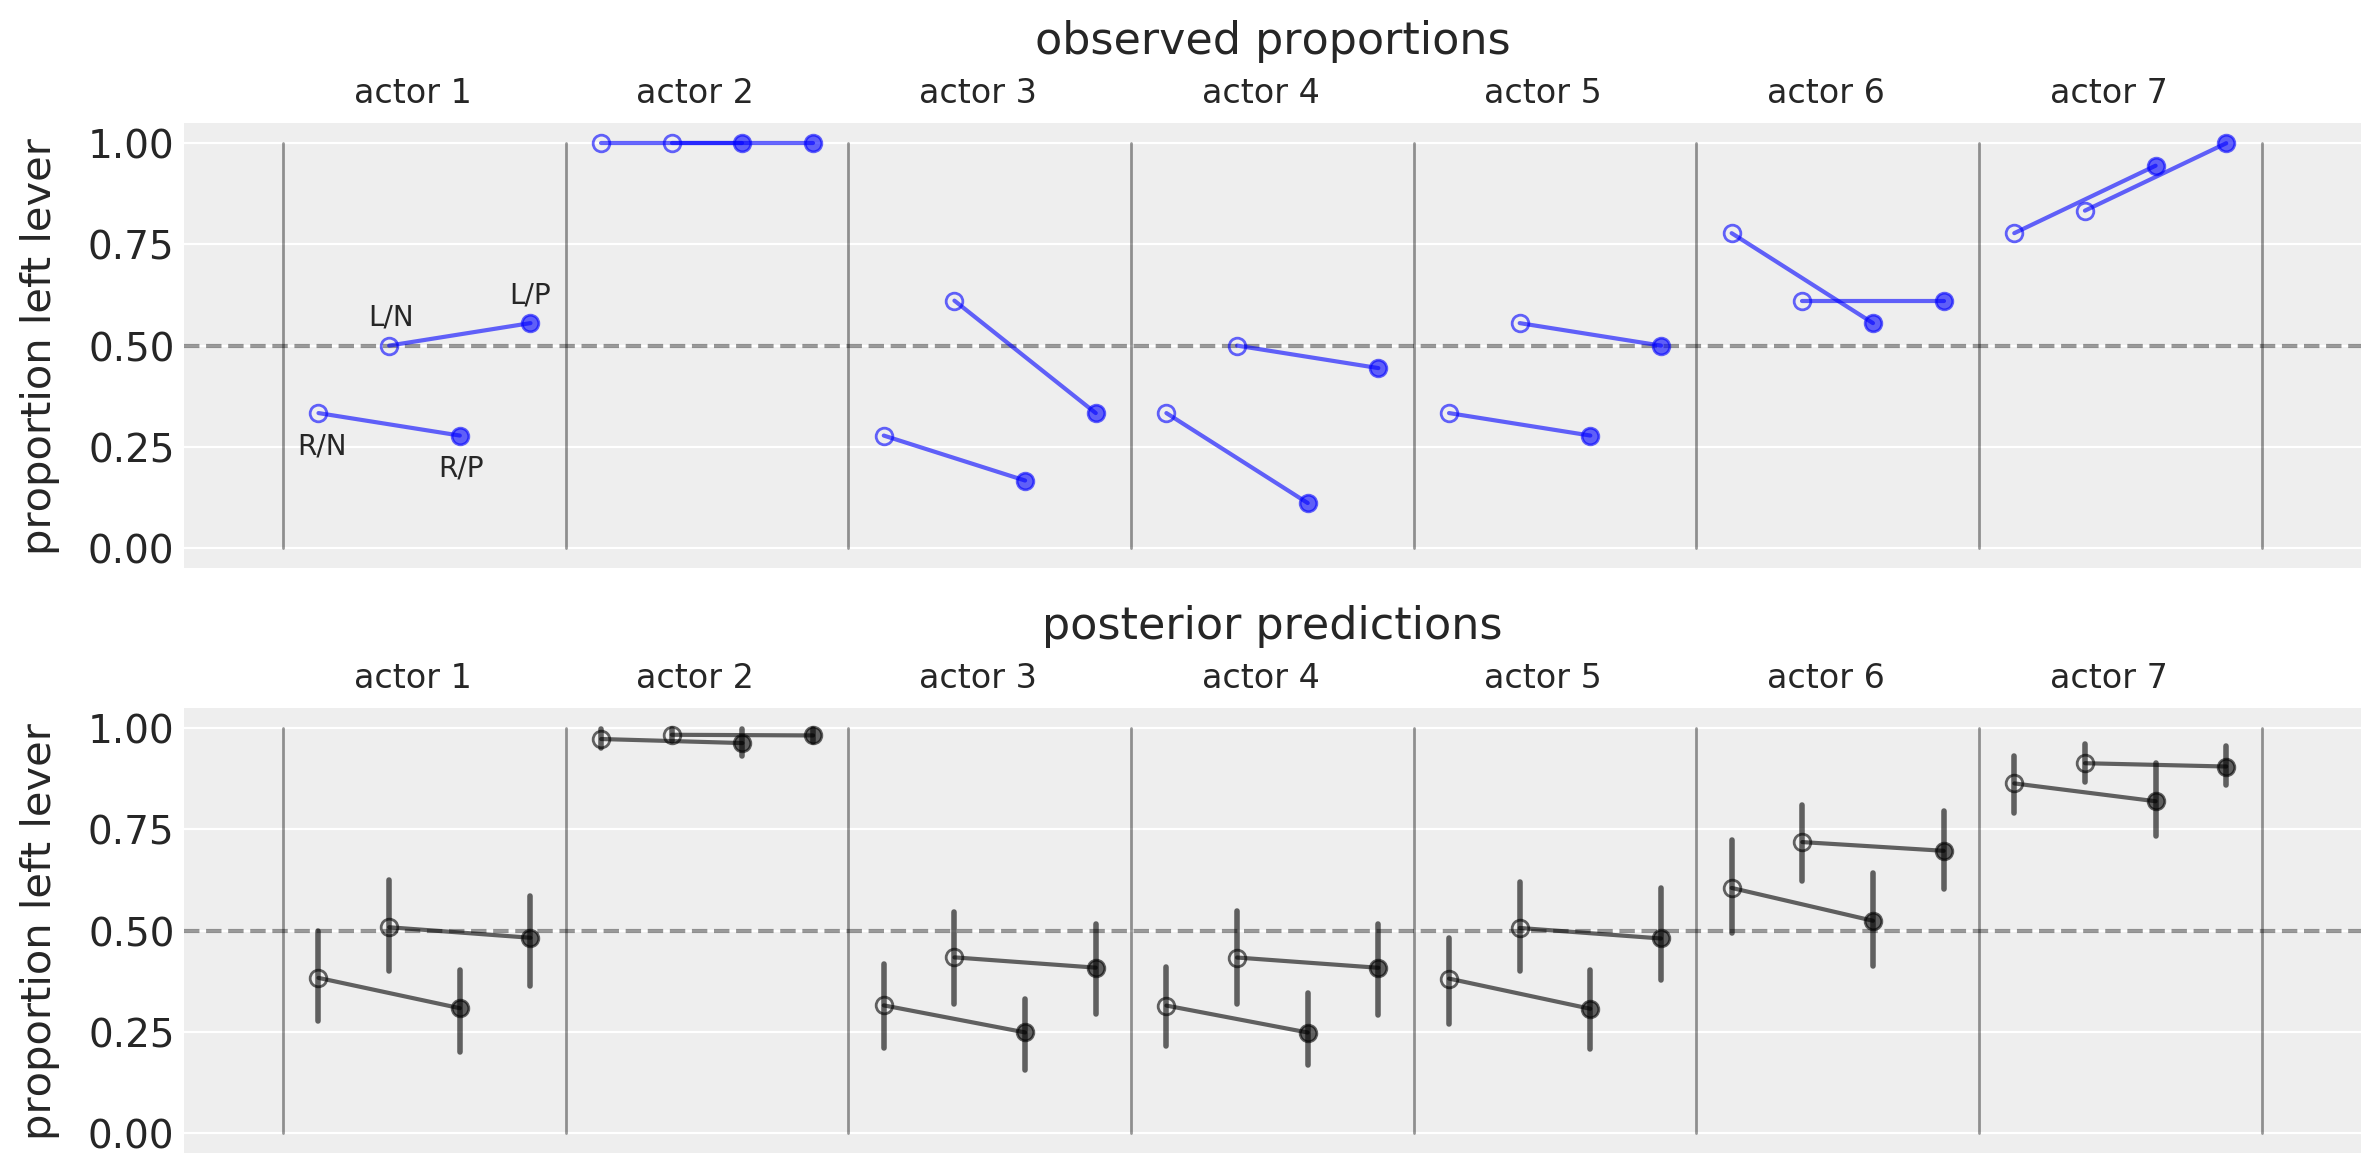

In [39]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot([actor * 4, actor * 4 + 2], [pl.loc[actor, 0], pl.loc[actor, 2]], "-",  c="b", alpha=alpha)
    ax0.plot([actor * 4 + 1, actor * 4 + 3], [pl.loc[actor, 1], pl.loc[actor, 3]], "-", c="b", alpha=alpha)
    ax0.plot([actor * 4, actor * 4 + 1], [pl.loc[actor, 0], pl.loc[actor, 1]], "o", c="b", fillstyle="none", ms=6, alpha=alpha)
    ax0.plot([actor * 4 + 2, actor * 4 + 3], [pl.loc[actor, 2], pl.loc[actor, 3]], "o", c="b", ms=6, alpha=alpha)
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hpd(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot([actor * 4, actor * 4 + 2], [p_mu[actor, 0], p_mu[actor, 2]], "-",  c="k", alpha=alpha)
    ax1.plot([actor * 4 + 1, actor * 4 + 3], [p_mu[actor, 1], p_mu[actor, 3]], "-", c="k", alpha=alpha)
    ax1.plot([actor * 4, actor * 4 + 1], [p_mu[actor, 0], p_mu[actor, 1]], "o", c="k", fillstyle="none", ms=6, alpha=alpha)
    ax1.plot([actor * 4 + 2, actor * 4 + 3], [p_mu[actor, 2], p_mu[actor, 3]], "o", c="k", ms=6, alpha=alpha)
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

#### Code 11.18

In [40]:
side = d.prosoc_left.values # right 0, left 1
cond = d.condition.values # no partner 0, partner 1

#### Code 11.19

In [41]:
with pm.Model() as m11_5:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    bs = pm.Normal('bs', 0., 0.5, shape=2)
    bc = pm.Normal('bc', 0., 0.5, shape=2)
    
    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_11_5 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, bs, a]


#### Code 11.20
As we changed the data of `m11_4` above, we need to sample from it again, with the original data:

In [42]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11_5,0,-265.436,7.82865,0,0.657098,9.45788,0,False,log
m11_4,1,-266.12,8.44339,0.683919,0.342902,9.58536,0.655022,False,log


#### Code 11.23

In [43]:
np.exp(trace_11_4["b"][:, 3] - trace_11_4["b"][:, 1]).mean().round(3)

0.933

#### Code 11.24

In [44]:
d_aggregated = d.groupby(["treatment", "actor"]).sum().reset_index()[["treatment", "actor", "pulled_left"]]
d_aggregated.head(10)

,treatment,actor,pulled_left
0,0,0,6
1,0,1,18
2,0,2,5
3,0,3,6
4,0,4,6
5,0,5,14
6,0,6,14
7,1,0,9
8,1,1,18
9,1,2,11


#### Code 11.25

In [45]:
with pm.Model() as m11_6:
    a = pm.Normal('a', 0., 1.5, shape=len(actors))
    b = pm.Normal('b', 0., 0.5, shape=len(treatments))
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d_aggregated.actor] + b[d_aggregated.treatment]))
    
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_11_6 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


#### Code 11.26
ArviZ won't even let you compare models with different observations:

In [46]:
az.compare({"m11_4": trace_11_4, "m11_6": trace_11_6})

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


ValueError: The number of observations should be the same across all models

#### Code 11.27

In [47]:
# deviance of aggregated 6-in-9 
(-2 * stats.binom.logpmf(6, 9, 0.2)).round(5)

11.79048

In [48]:
# deviance of dis-aggregated 
-2 * stats.bernoulli.logpmf([1,1,1,1,1,1,0,0,0], 0.2).sum().round(5)

20.65212

#### Code 11.28

In [49]:
d_ad = pd.read_csv('Data/UCBadmit.csv', sep=';')
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


#### Code 11.29

In [50]:
gid = (d_ad['applicant.gender'] == 'female').astype(int).values
    
with pm.Model() as m11_7:
    a = pm.Normal('a', 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_11_7 = pm.sample(tune=1000, random_seed=RANDOM_SEED)
az.summary(trace_11_7, var_names=["a"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.04,-0.28,-0.16,0.0,0.0,1521.56,1521.56,1535.13,1297.72,1.0
a[1],-0.83,0.05,-0.91,-0.75,0.0,0.0,1943.13,1937.38,1934.72,1492.93,1.0


#### Code 11.30

In [51]:
diff_a = trace_11_7["a"][:, 0] - trace_11_7["a"][:, 1]
diff_p = logistic(trace_11_7["a"][:, 0]) - logistic(trace_11_7["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,0.61,0.07,0.51,0.72
diff_p,0.14,0.01,0.12,0.17


#### Code 11.31

In [52]:
with m11_7:
    ppc = pm.sample_posterior_predictive(trace_11_7, random_seed=RANDOM_SEED, var_names=["admit"])["admit"]
pp_admit = ppc / d_ad.applications.values[None, :]

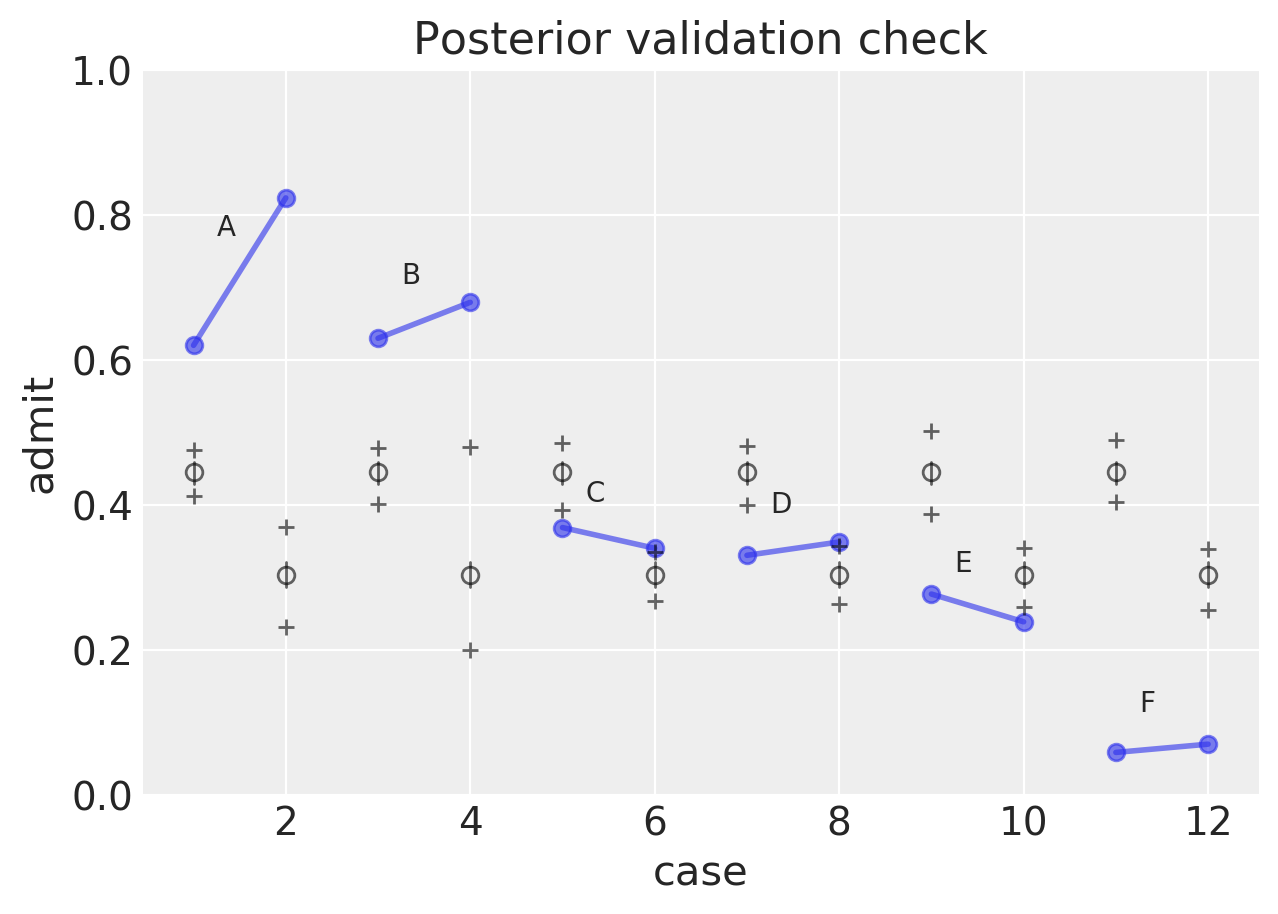

In [53]:
for i in range(6):
    x = 1 + 2 * i
    
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]

    plt.plot([x, x+1], [y1, y2], '-C0o', alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])

plt.plot(range(1, 13), trace_11_7["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_11_7["p"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

#### Code 11.32

In [54]:
dept_id = pd.Categorical(d_ad['dept']).codes

with pm.Model() as m11_8:
    a = pm.Normal('a', 0, 1.5, shape=2)
    delta = pm.Normal('delta', 0, 1.5, shape=6)
    
    p = pm.math.invlogit(a[gid] + delta[dept_id])
    
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_11_8 = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED)
az.summary(trace_11_8, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.52,0.56,-1.37,0.43,0.02,0.01,711.36,711.36,718.05,616.07,1.0
a[1],-0.42,0.57,-1.27,0.52,0.02,0.02,711.63,698.21,718.27,590.41,1.0
delta[0],1.10,0.57,0.22,2.03,0.02,0.01,713.67,713.67,720.04,640.26,1.0
delta[1],1.05,0.57,0.15,1.96,0.02,0.01,726.81,726.81,733.39,593.29,1.0
delta[2],-0.16,0.57,-1.10,0.71,0.02,0.02,714.16,459.55,721.01,595.16,1.0
delta[3],-0.20,0.57,-1.11,0.69,0.02,0.02,710.88,455.28,716.07,644.38,1.0
delta[4],-0.64,0.57,-1.53,0.29,0.02,0.02,724.36,538.16,730.41,630.04,1.0
delta[5],-2.20,0.58,-3.12,-1.29,0.02,0.02,747.32,694.73,753.37,691.83,1.0


#### Code 11.33

In [55]:
diff_a = trace_11_8["a"][:, 0] - trace_11_8["a"][:, 1]
diff_p = logistic(trace_11_8["a"][:, 0]) - logistic(trace_11_8["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,-0.10,0.08,-0.22,0.03
diff_p,-0.02,0.02,-0.05,0.01


#### Code 11.34

In [56]:
pg = pd.DataFrame(index=["male", "female"], columns=d_ad.dept.unique())
for dep in pg.columns:
    pg[dep] = (d_ad.loc[d_ad.dept == dep, "applications"] / d_ad.loc[d_ad.dept == dep, "applications"].sum()).values
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


#### Code 11.35

In [57]:
y = np.random.binomial(n=1000, p=1/1000, size=10_000) 
y.mean(), y.var()

(1.0022, 1.0089951599999998)

#### Code 11.36

In [3]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 11.37

In [4]:
dk["P"] = standardize(np.log(dk.population))
dk["contact_id"] = (dk.contact == "high").astype(int)

#### Code 11.38

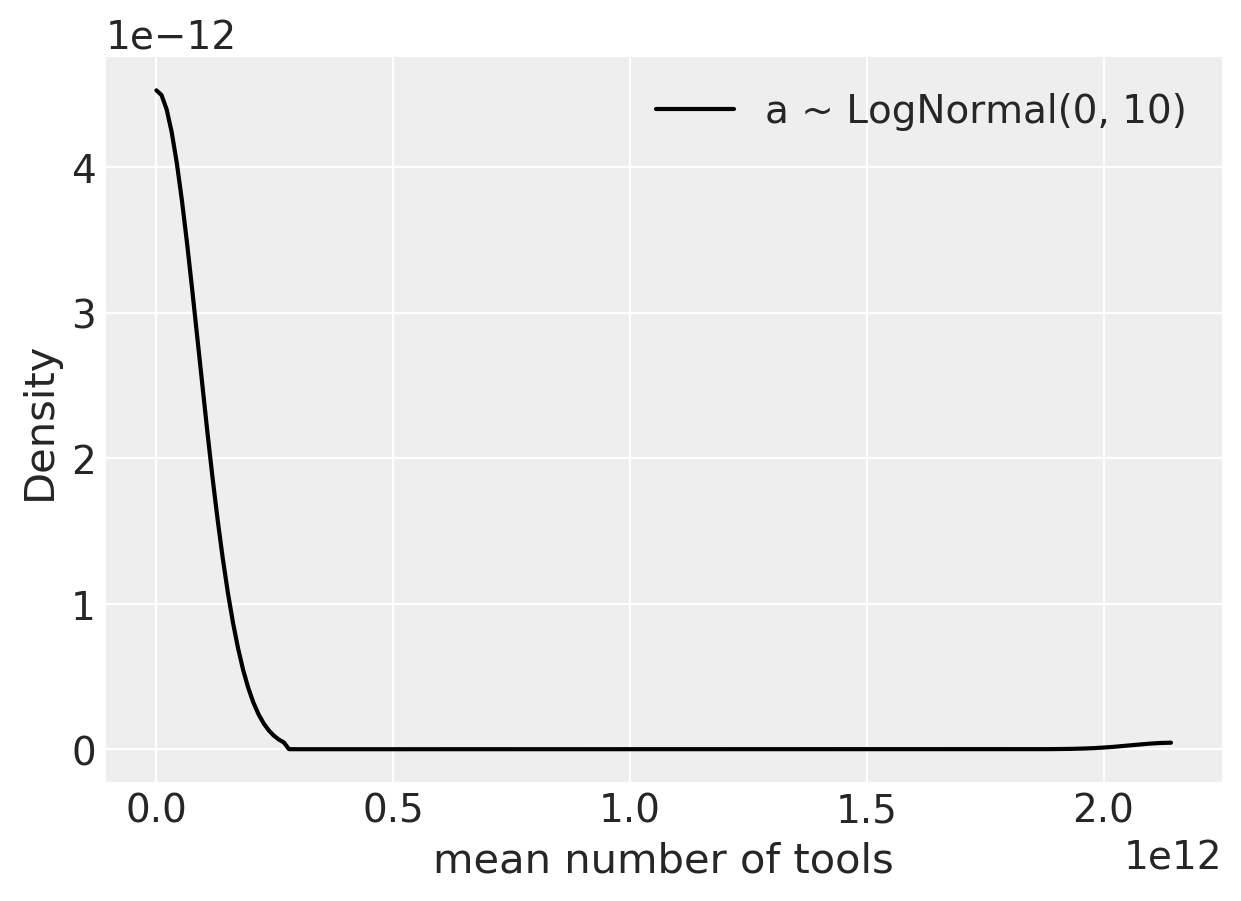

In [5]:
ax = az.plot_kde(pm.Lognormal.dist(0., 10.).random(size=200), label="a ~ LogNormal(0, 10)", plot_kwargs={"color": "k"})
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.39

In [6]:
a = np.random.normal(0., 10., size=10_000)
np.exp(a).mean()

5208551972312.05

#### Code 11.40

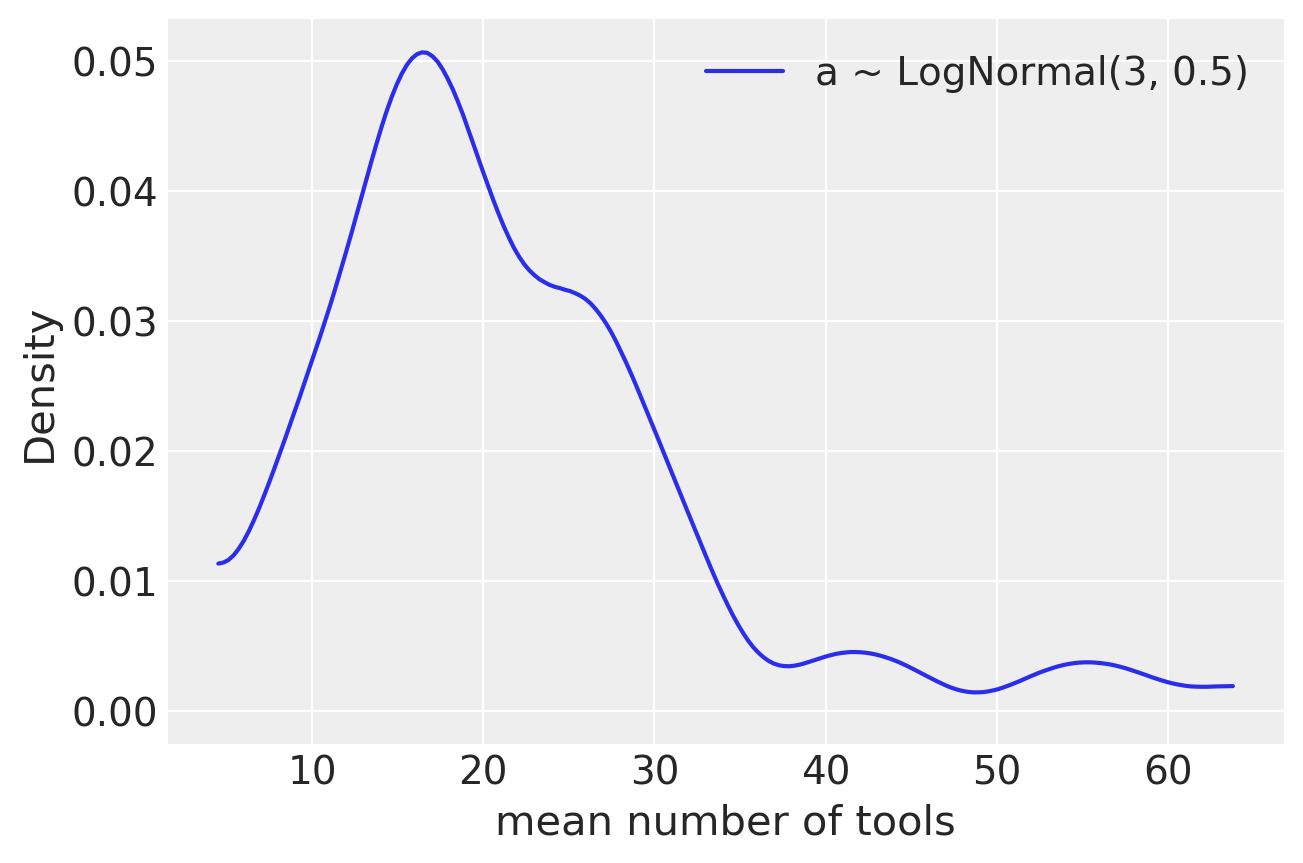

In [7]:
ax = az.plot_kde(pm.Lognormal.dist(3., 0.5).random(size=200), label="a ~ LogNormal(3, 0.5)")
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

#### Code 11.41 to 11.44

In [22]:
def kline_prior_plot(N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None):
    """
    Utility function to plot prior predictive checks for Kline Poisson model.
    N: number of prior predictive trends.
    
    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tools")
    
    itcpts = np.random.normal(3., 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0., 10., N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0., 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError("Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'.")
    
    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("log population")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("population")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("log population (std)")
    
    return ax

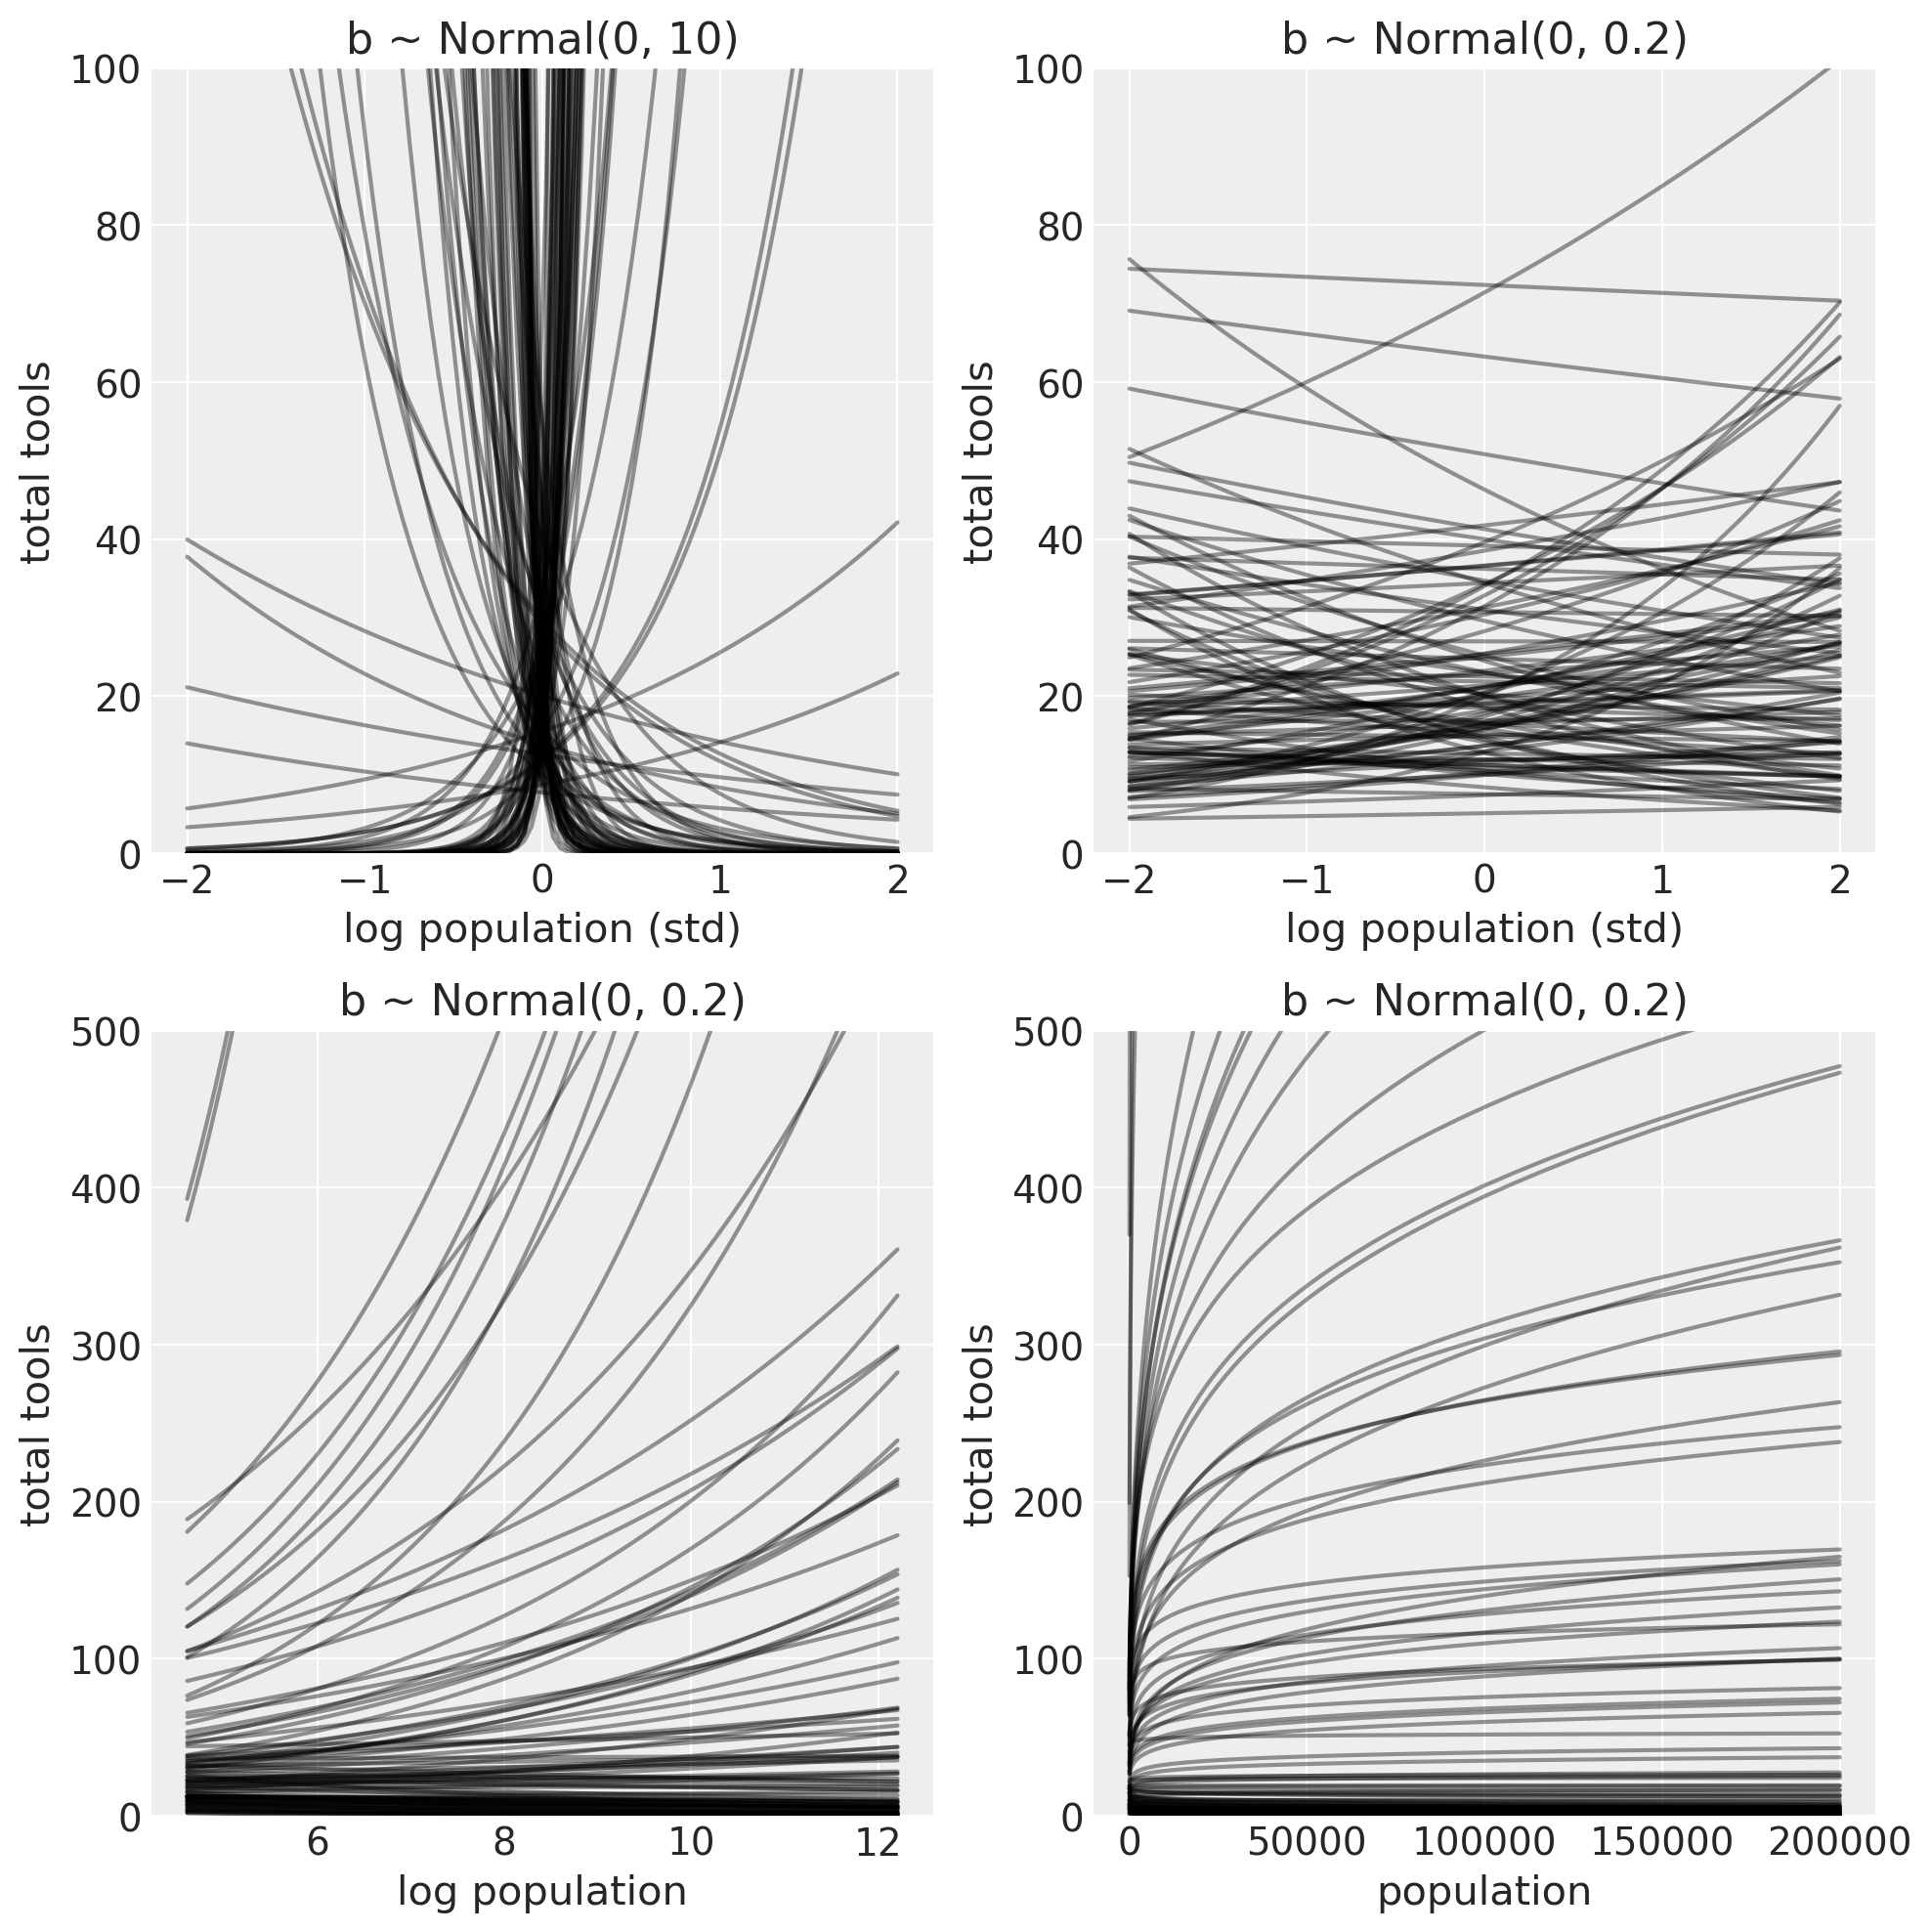

In [23]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout();

#### Code 11.45

In [46]:
from theano import shared
# casting data to theano shared variable. 
# It is for out of sample prediction from model with sampled trace
log_pop = shared(dk.log_pop.values)
contact_high = shared(dk.contact_high.values)
total_tools = shared(dk.total_tools.values)

#### Code 10.41

In [47]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


#### Code 10.42

In [48]:
summary = az.summary(trace_10_10, credible_interval=.89)[['mean', 'sd', 'hpd_5.5%', 'hpd_94.5%']]
trace_cov = pm.trace_cov(trace_10_10, model=m_10_10)
invD = (np.sqrt(np.diag(trace_cov))**-1)[:, None]
trace_corr = pd.DataFrame(invD*trace_cov*invD.T, index=summary.index, columns=summary.index)

summary.join(trace_corr).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,a,b[0],b[1],b[2]
a,0.93,0.36,0.34,1.49,1.00,-0.98,-0.03,-0.03
b[0],0.26,0.04,0.21,0.32,-0.98,1.00,0.03,0.01
b[1],-0.09,0.84,-1.48,1.20,-0.03,0.03,1.00,-0.99
b[2],0.04,0.09,-0.11,0.19,-0.03,0.01,-0.99,1.00


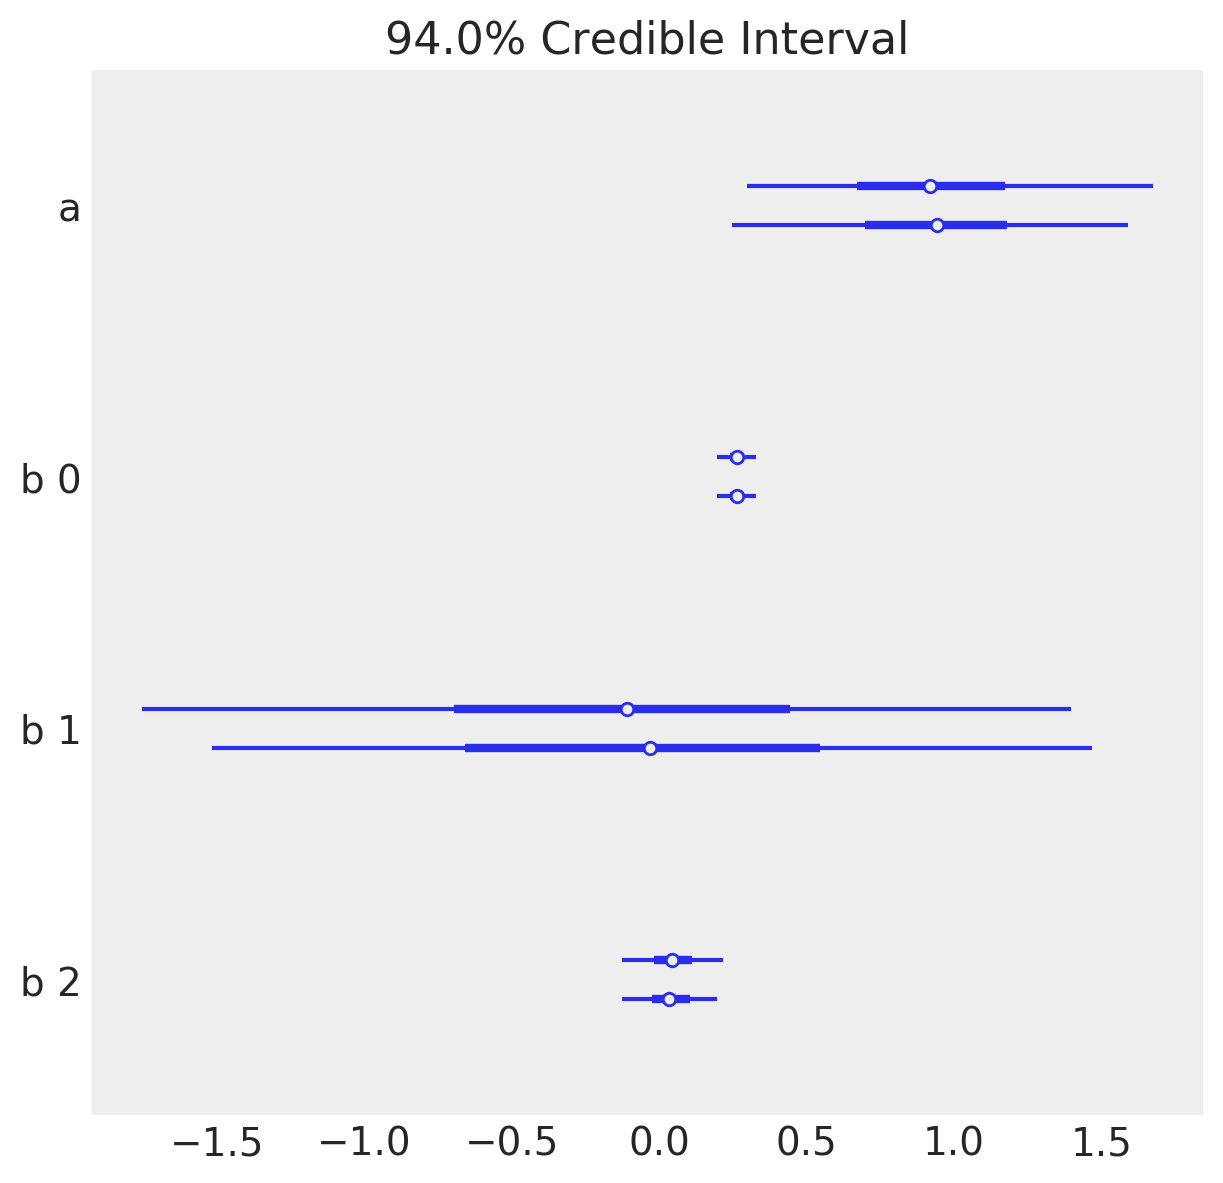

In [49]:
az.plot_forest(trace_10_10);

#### Code 10.43

In [50]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [51]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

0.9625

#### Code 10.45

In [52]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


#### Code 10.46

In [53]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


The acceptance probability does not match the target. It is 0.8835601127234468, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]




#### Code 10.47

In [54]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


In [55]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]
model_names = ['m10.10', 'm10.11', 'm10.12', 'm10.13','m10.14']

dictionary = dict(zip(model_names, traces))

islands_compare = az.compare(dictionary)

islands_compare

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:1078: UserWarning: For one or more sampl

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10.11,79.355,4.39772,0,0.503126,11.2484,0,True,deviance
m10.10,80.6378,5.15511,1.28279,0.276046,10.9265,1.18494,True,deviance
m10.12,84.4378,3.74629,5.08275,0.219833,8.54095,7.74886,True,deviance
m10.14,141.562,8.28172,62.2074,0.000230229,43.6218,32.9269,True,deviance
m10.13,150.564,16.7978,71.2093,0.000765188,30.4152,44.7903,True,deviance


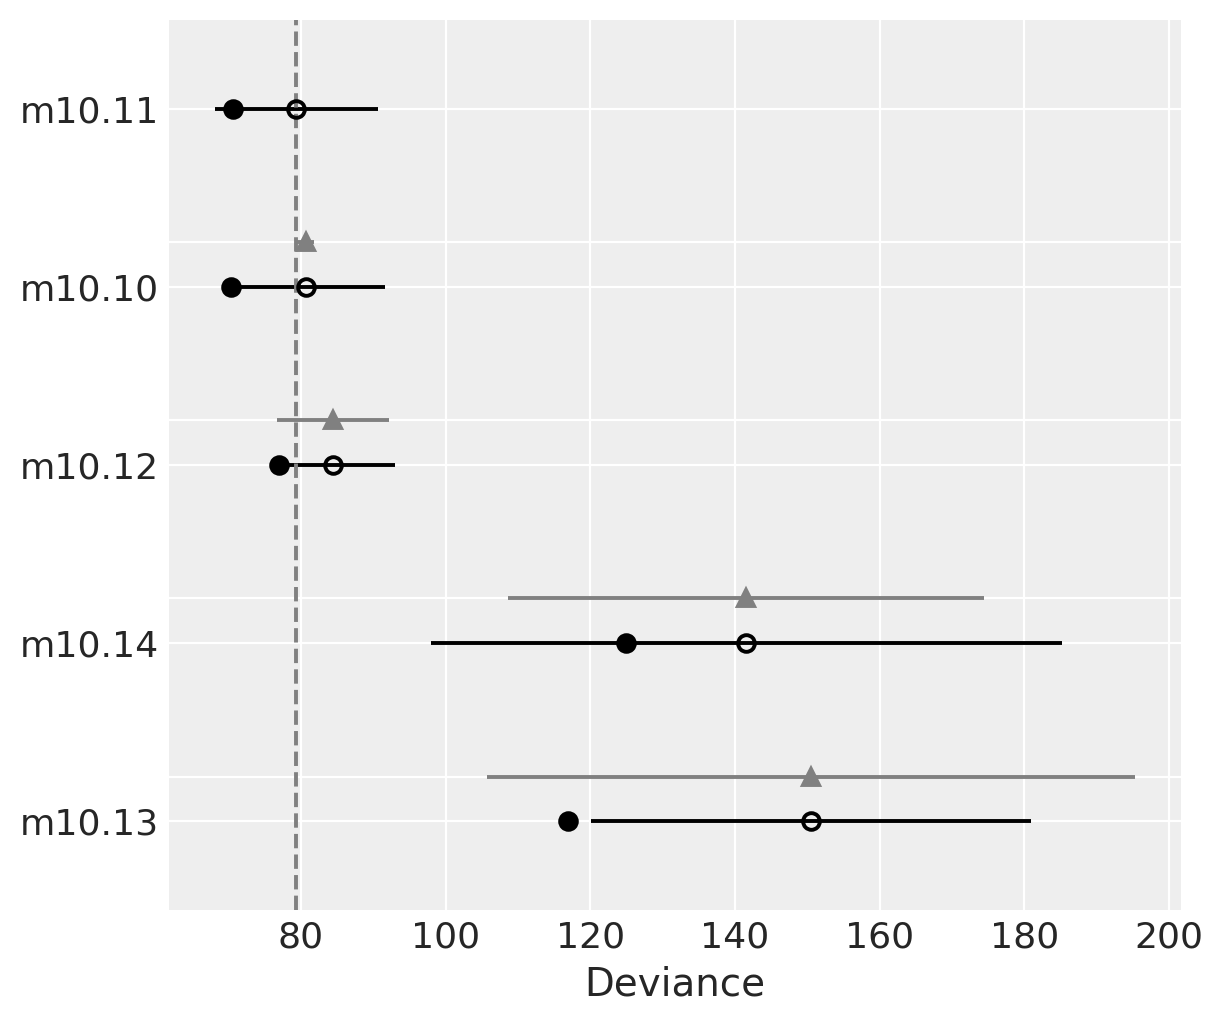

In [56]:
az.plot_compare(islands_compare);

#### Code 10.48

In [57]:
# set new value for out-of-sample prediction 
log_pop_seq = np.linspace(6, 13, 30)
log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
contact_high.set_value(np.hstack([np.repeat(0, 30), np.repeat(1, 30)]))

islands_ensemble = pm.sample_posterior_predictive_w(traces, 10000, models,
                                                    weights=islands_compare.weight.sort_index(ascending=True))

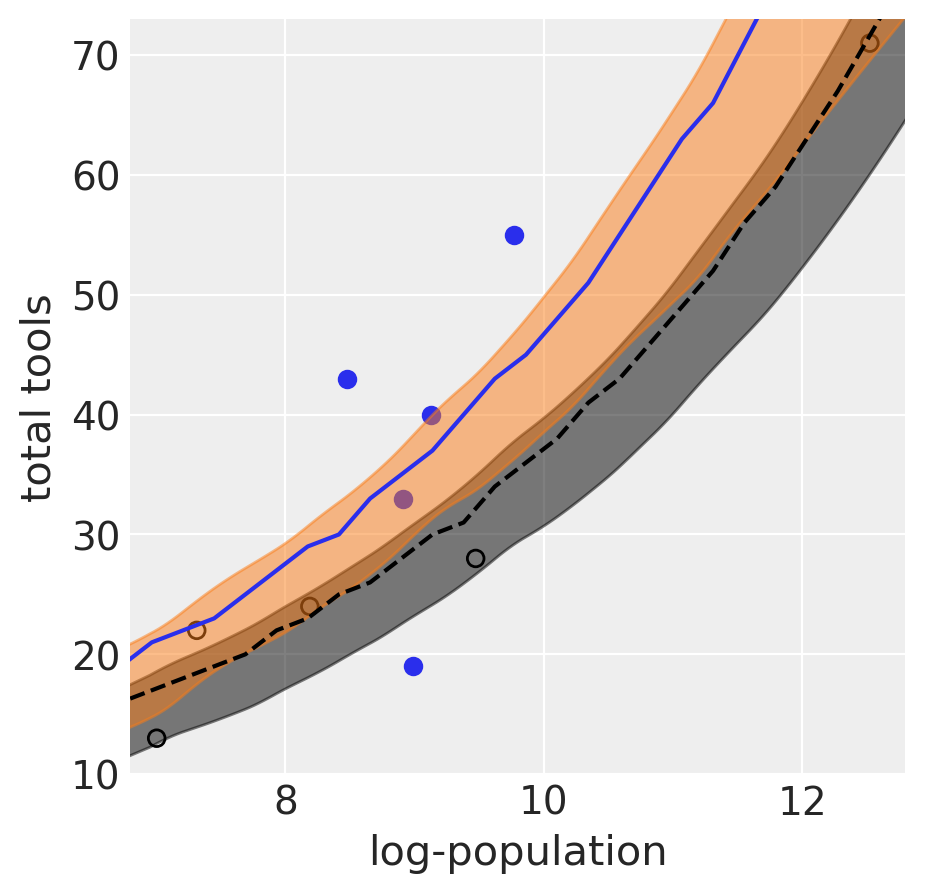

In [58]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
index = dk.contact_high==1
axes.scatter(np.log(dk.population)[~index], dk.total_tools[~index],
             facecolors='none', edgecolors='k', lw=1)
axes.scatter(np.log(dk.population)[index], dk.total_tools[index])

mp = islands_ensemble['total_tools'][:, :30]


axes.plot(log_pop_seq, np.median(mp, axis=0), '--', color='k')
az.plot_hpd(log_pop_seq, mp, credible_interval=.5, color='k')

mp = islands_ensemble['total_tools'][:, 30:]

axes.plot(log_pop_seq, np.median(mp, axis=0))
az.plot_hpd(log_pop_seq, mp, credible_interval=.5)

axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 10.49
This is the same as 10.41, but in the book using MCMC rather than MAP.

#### Code 10.50

In [59]:
log_pop_c = dk.log_pop.values - dk.log_pop.values.mean()
log_pop.set_value(log_pop_c)
contact_high.set_value(dk.contact_high.values)
total_tools.set_value(dk.total_tools.values)

with pm.Model() as m_10_10c:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10c = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


In [60]:
az.summary(trace_10_10c, credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,3.31,0.09,3.19,3.46,0.0,0.0,1218.90,1216.39,1217.22,1218.70,1.0
b[0],0.26,0.04,0.21,0.33,0.0,0.0,1571.34,1560.62,1578.04,1140.98,1.0
b[1],0.28,0.12,0.10,0.47,0.0,0.0,1292.44,1277.52,1293.50,1549.39,1.0
b[2],0.06,0.17,-0.21,0.32,0.0,0.0,1409.02,1272.78,1408.09,1396.35,1.0


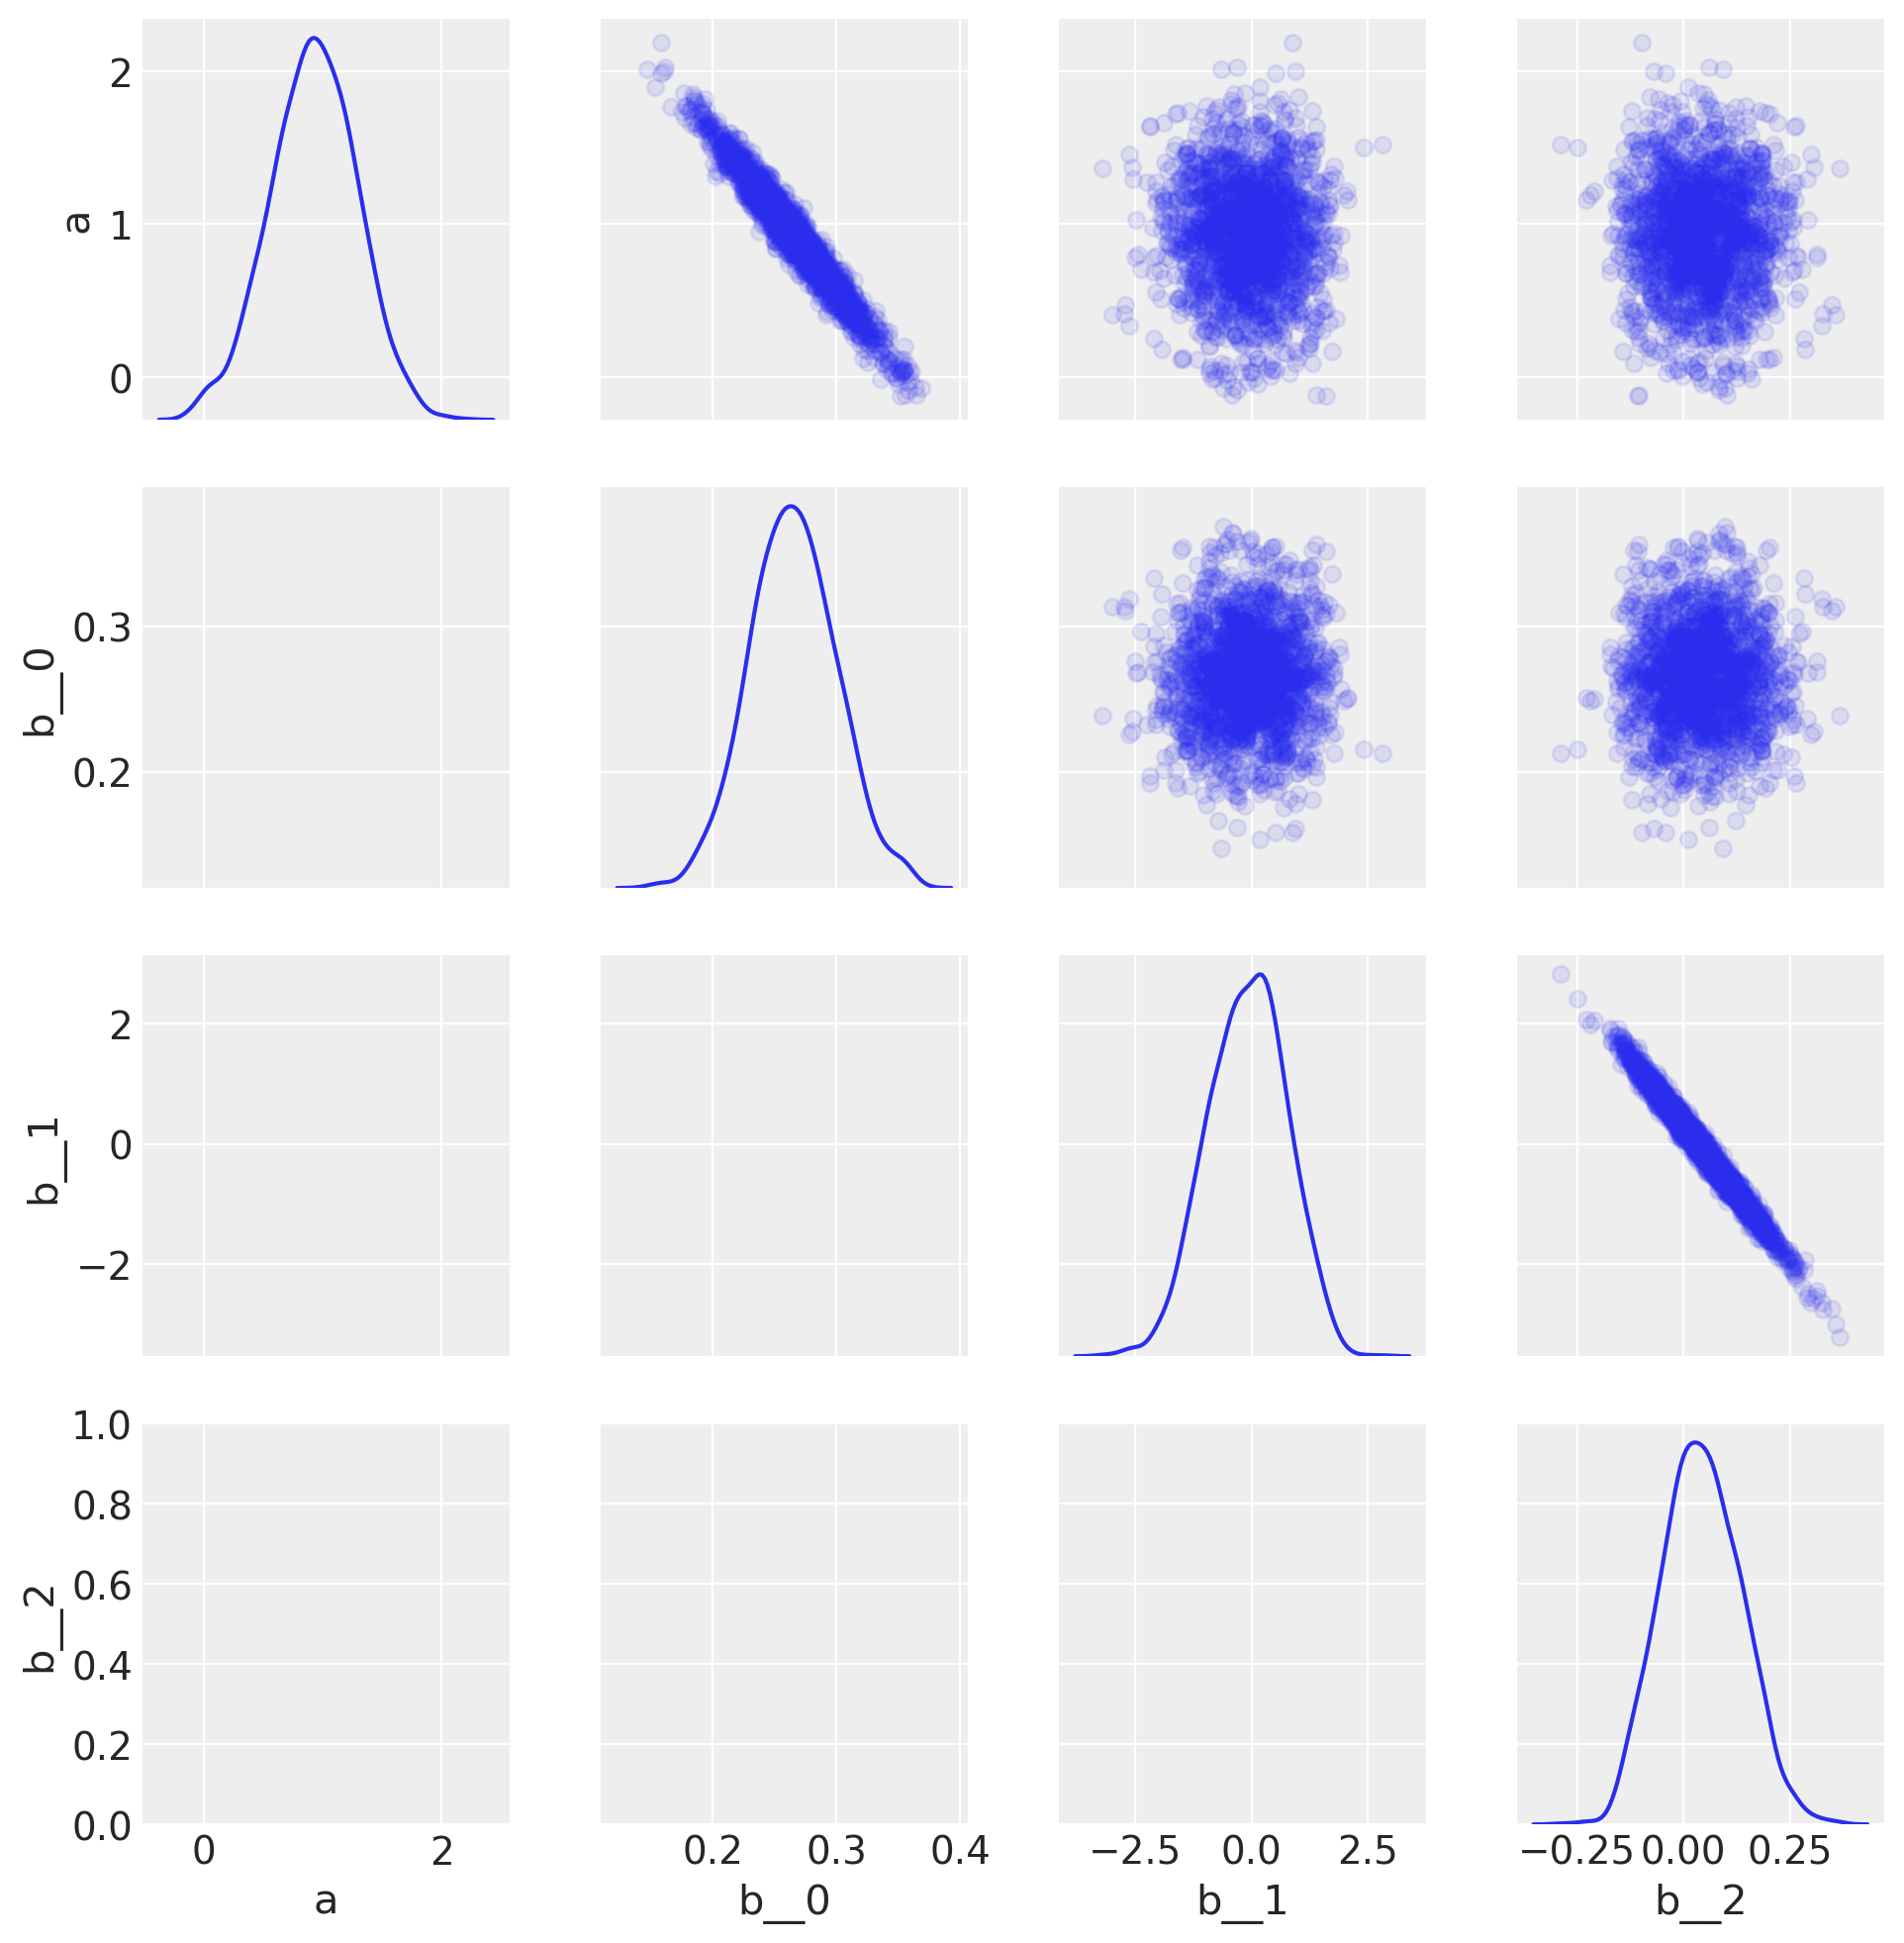

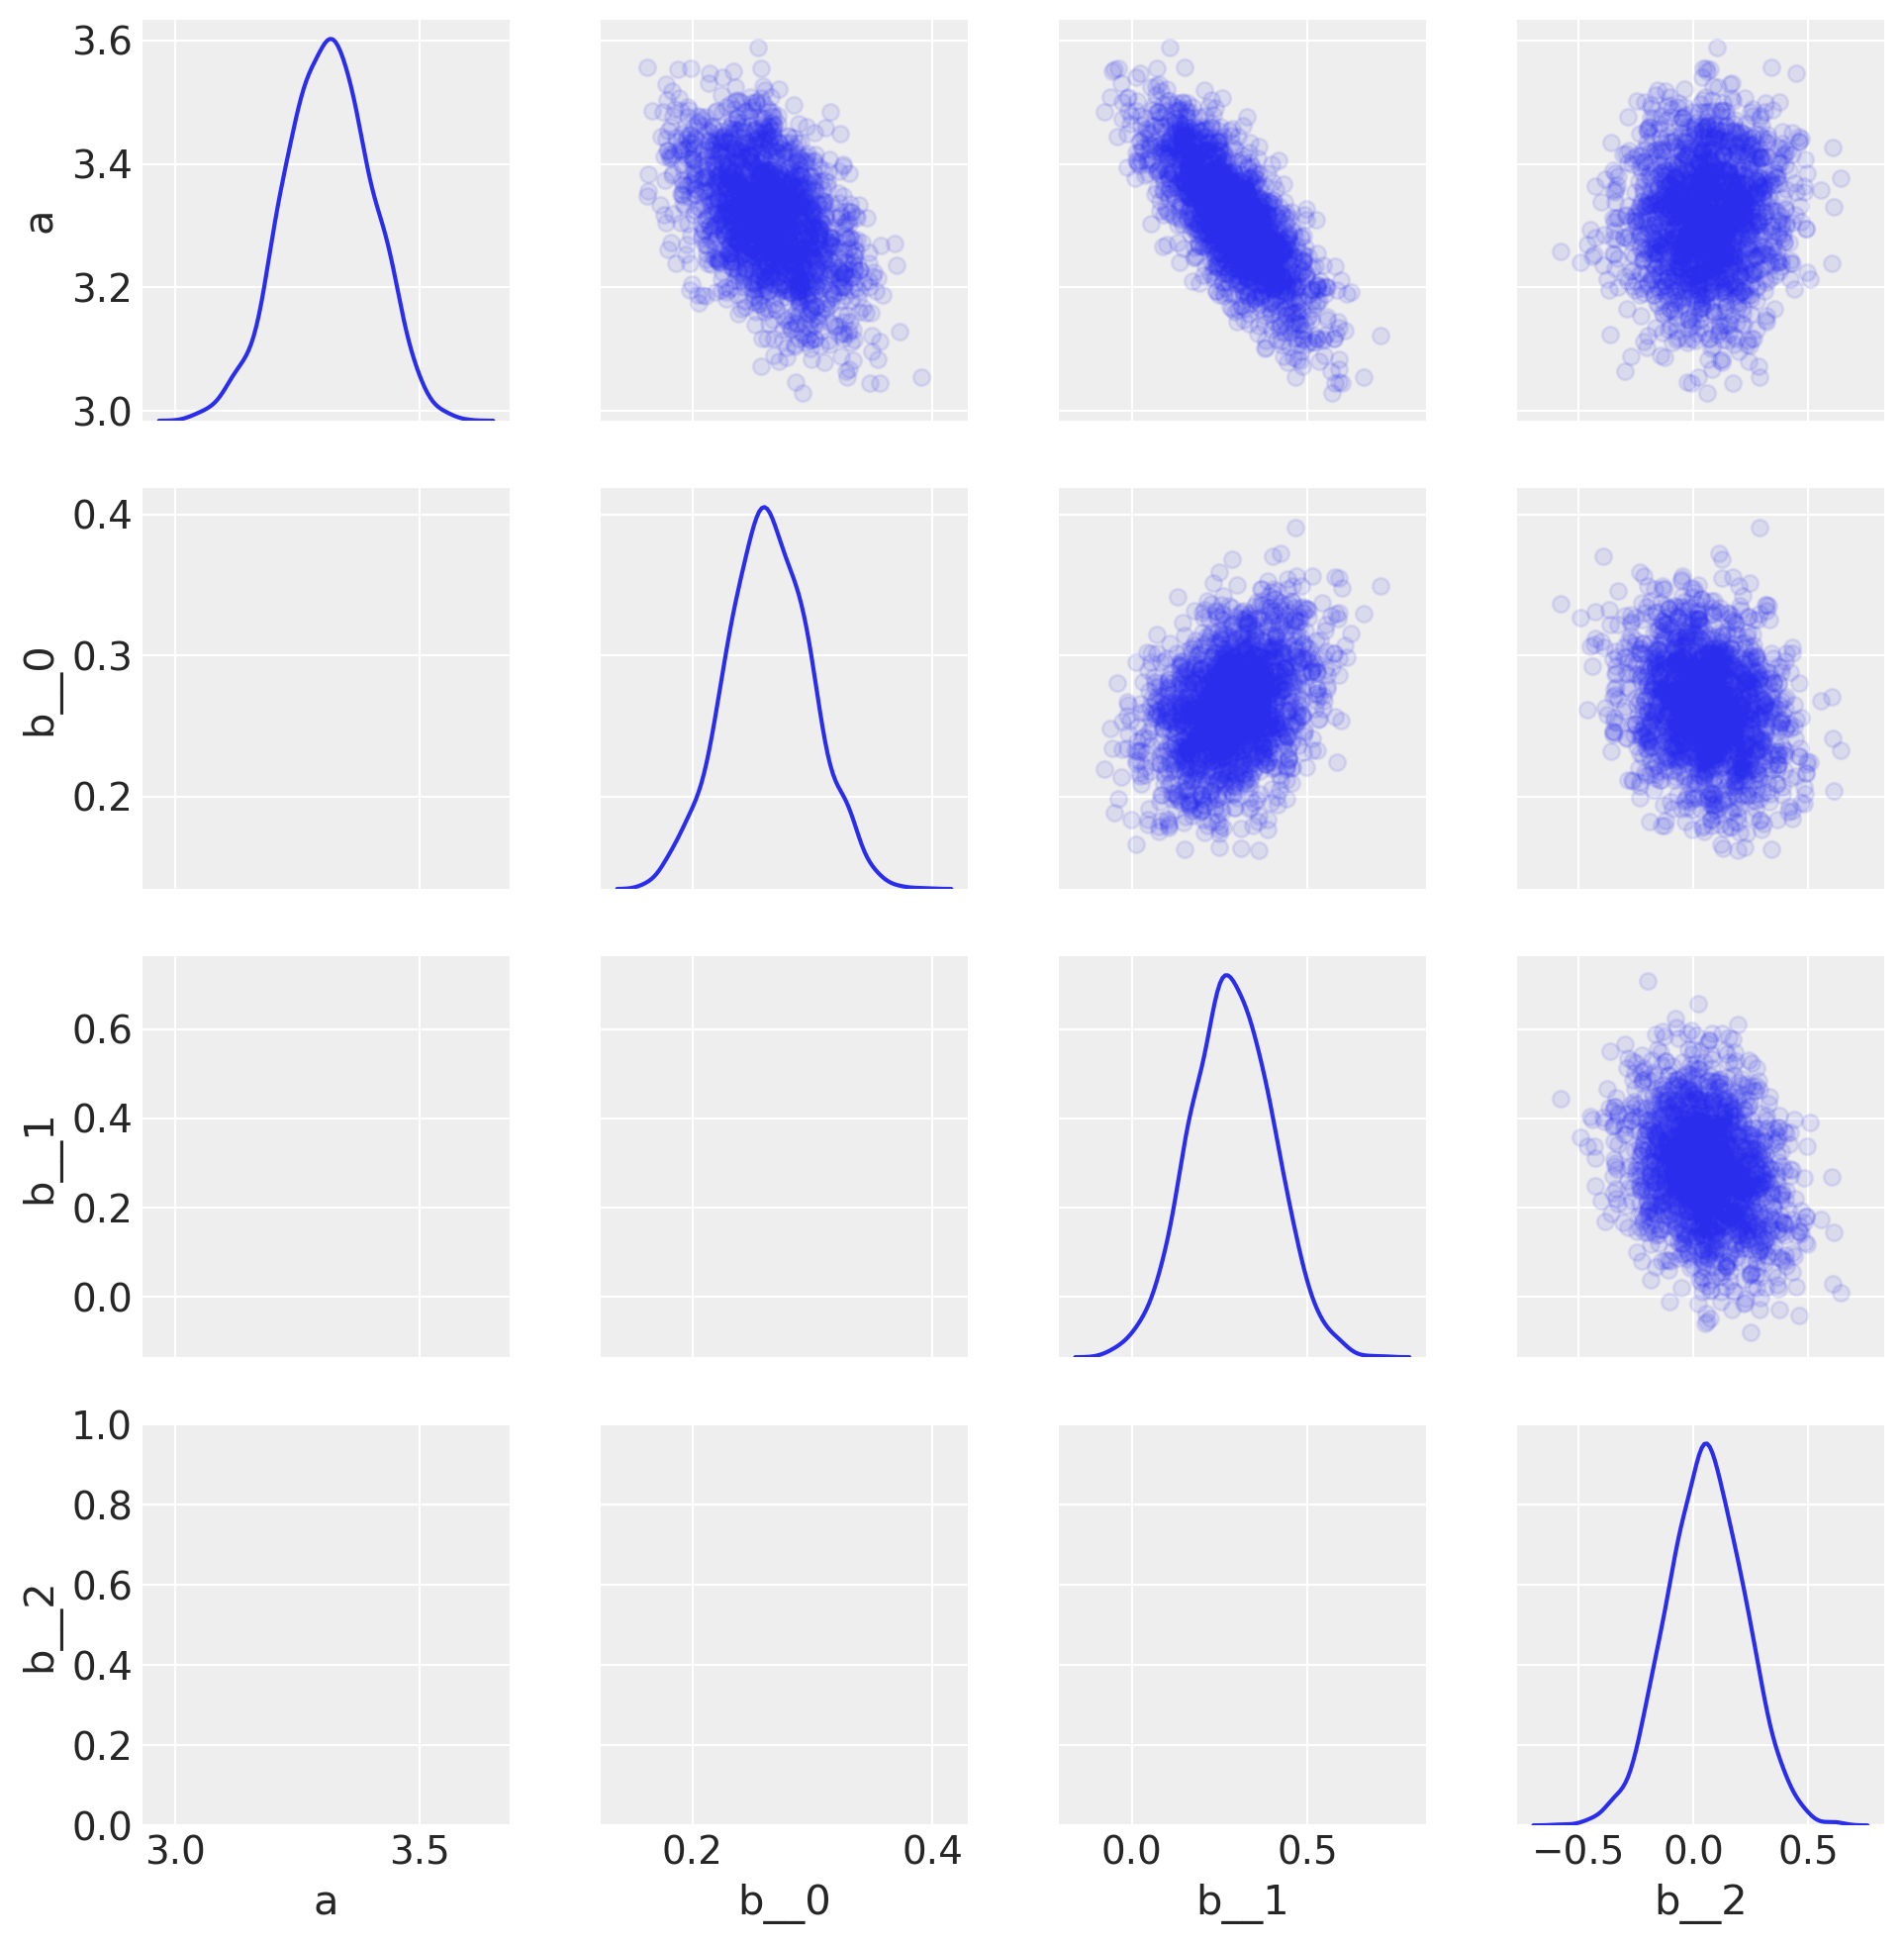

In [61]:
for trace in [trace_10_10, trace_10_10c]:
    tracedf = pm.trace_to_dataframe(trace)
    grid = (sns.PairGrid(tracedf,
                         diag_sharey=False)
               .map_diag(sns.kdeplot)
               .map_upper(plt.scatter, alpha=0.1))

#### Code 10.51

In [62]:
num_days = 30
y = np.random.poisson(1.5, num_days)

#### Code 10.52

In [63]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)

#### Code 10.53

In [64]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype('float')
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])

#### Code 10.54

In [65]:
log_days = np.log(exposure)
with pm.Model() as m_10_15:
    a = pm.Normal('a', 0., 100.)
    b = pm.Normal('b', 0., 1.)
    lam = pm.math.exp(log_days + a + b*monastery)
    obs = pm.Poisson('y', lam, observed=y_all)
    trace_10_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


#### Code 10.55

In [66]:
trace_10_15.add_values(dict(lambda_old=np.exp(trace_10_15['a']),
                            lambda_new=np.exp(trace_10_15['a'] + trace_10_15['b'])))

az.summary(trace_10_15, var_names=['lambda_old', 'lambda_new'],
           credible_interval=.89, round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_old,1.95,0.25,1.54,2.34,0.01,0.0,1474.08,1474.08,1455.16,1299.94,1.0
lambda_new,0.51,0.13,0.29,0.70,0.00,0.0,1589.43,1589.43,1525.23,1421.27,1.0


#### Code 10.56

In [2]:
# simulate career choices among 500 individuals
N = 500                 # number of individuals
income = np.arange(3) + 1 # expected income of each career
score = 0.5 * income      # scores for each career, based on income

# next line converts scores to probabilities
def softmax(w):
    e = np.exp(w)
    return e/np.sum(e, axis=0)
p = softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career==1)[1]
career[:11]

array([1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 2])

#### Code 10.57

In [3]:
with pm.Model() as m_10_16:
    b = pm.Normal('b', 0., 5.)
    s2 = b*2
    s3 = b*3
    
    p_ = pm.math.stack([0, s2, s3])
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    
    trace_10_16 = pm.sample(1000, tune=2000, cores=2)
    
az.summary(trace_10_16, credible_interval=.89, round_to=2)

/anaconda/envs/fund/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 530.57draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.33,0.04,0.27,0.4,0.0,0.0,615.94,615.94,623.48,1125.77,1.01


#### Code 10.58

In [4]:
N = 100

# simulate family incomes for each individual
family_income = np.random.rand(N)

# assign a unique coefficient for each type of event
b = np.arange(3)-1

p = softmax(score[:, None] + np.outer(b, family_income)).T

career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]
career

array([1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0])

In [5]:
with pm.Model() as m_10_17:
    a23 = pm.Normal('a23', 0., 5., shape=2)
    b23 = pm.Normal('b23', 0., 5., shape=2)
    
    s2 = a23[0] + b23[0]*family_income
    s3 = a23[1] + b23[1]*family_income
    
    p_ = pm.math.stack([np.zeros(N), s2, s3]).T
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    
    trace_10_17 = pm.sample(1000, tune=2000, cores=2)
    
az.summary(trace_10_17, credible_interval=.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b23, a23]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:38<00:00, 157.53draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a23[0],0.87,0.76,-0.37,2.03,0.03,0.02,555.77,555.77,557.28,788.43,1.0
a23[1],1.76,0.68,0.70,2.86,0.03,0.02,549.78,527.32,557.30,691.57,1.0
b23[0],0.27,1.27,-1.99,2.07,0.05,0.04,569.73,569.73,570.80,842.66,1.0
b23[1],0.34,1.15,-1.32,2.29,0.05,0.03,560.08,560.08,557.17,834.00,1.0


#### Code 10.59

In [71]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')

#### Code 10.60

In [72]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    trace_binom = pm.sample(1000, tune=1000)
    
# Poisson model of overall admission rate and rejection rate
with pm.Model() as m_pois:
    a = pm.Normal('a', 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson('admit', lam[0], observed=d_ad.admit)
    rej = pm.Poisson('rej', lam[1], observed=d_ad.reject)
    trace_pois = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]


#### Code 10.61

In [73]:
m_binom = pm.summary(trace_binom, alpha=.11).round(2)
logistic(m_binom['mean'])

a    0.386986
Name: mean, dtype: float64

#### Code 10.62

In [74]:
m_pois = pm.summary(trace_pois, alpha=.11).round(2)
m_pois['mean'][0]
np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))

0.38936076605077796

#### Code 10.63

In [75]:
# simulate
N = 100
x = np.random.rand(N)
y = np.random.geometric(logistic(-1 + 2*x), size=N)

with pm.Model() as m_10_18:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric('y', p=p, observed=y)
    trace_10_18 = pm.sample(1000, tune=1000)
az.summary(trace_10_18, credible_interval=.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.98,0.22,-1.33,-0.64,0.01,0.01,644.24,635.21,646.45,666.90,1.0
b,1.85,0.44,1.16,2.55,0.02,0.01,662.98,662.52,664.11,817.05,1.0


In [76]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
ArviZ 0.4.1
NumPy 1.16.4
SciPy 1.2.1
Matplotlib 3.1.0

